# Import Module

In [1]:
# Dataframe
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Statistic
from scipy.stats import shapiro, kstest, jarque_bera, ttest_1samp, norm
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Error measurement
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'pmdarima'

In [5]:
import warnings
warnings.simplefilter(action = "ignore")

# Definition function

In [6]:
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Import data

2000-01-01    320.353
2000-02-01    333.404
2000-03-01    366.512
2000-04-01    362.737
2000-05-01    361.371
Freq: MS, Name: Total Renewable Energy Consumption, dtype: float64


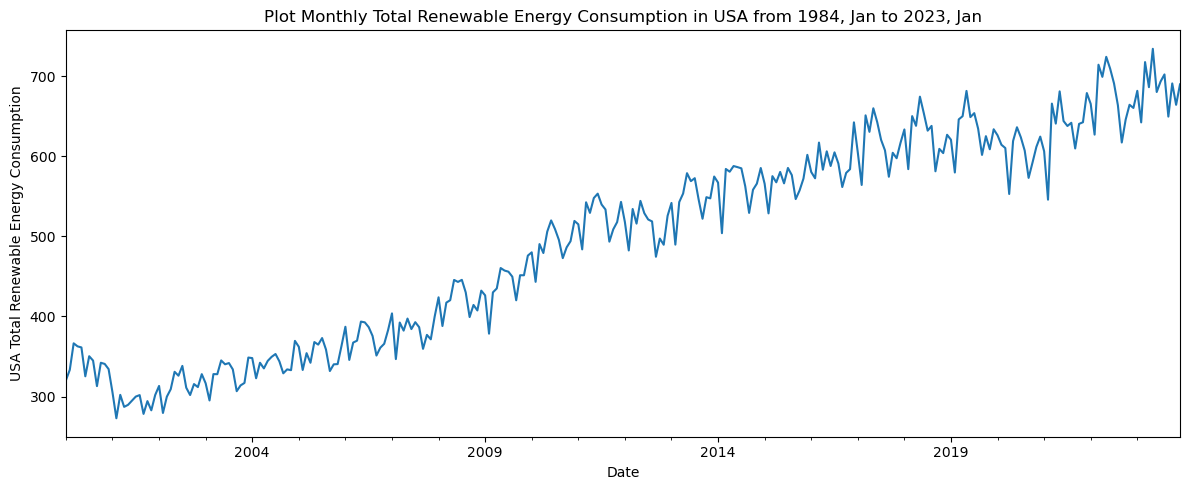

In [7]:
# Import Variables
renew = pd.read_excel(r"Dataset/Renewable_Energy_Production_by_Source.xlsx", skiprows = 10)["Total Renewable Energy Consumption"][:-7]

# contribute TSA
renew.index = pd.date_range(start = "1984-01", periods = len(renew), freq = "ME").to_period()
renew.index = renew.index.to_timestamp()
renew = renew.loc["2000-01-01":]
print(renew.head())
renew.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption",
           title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2023, Jan", figsize = (12, 5))
plt.tight_layout()
plt.show()

In [8]:
renew

2000-01-01    320.353
2000-02-01    333.404
2000-03-01    366.512
2000-04-01    362.737
2000-05-01    361.371
               ...   
2023-08-01    702.095
2023-09-01    649.474
2023-10-01    690.855
2023-11-01    664.158
2023-12-01    689.722
Freq: MS, Name: Total Renewable Energy Consumption, Length: 288, dtype: float64

# Data Visualization

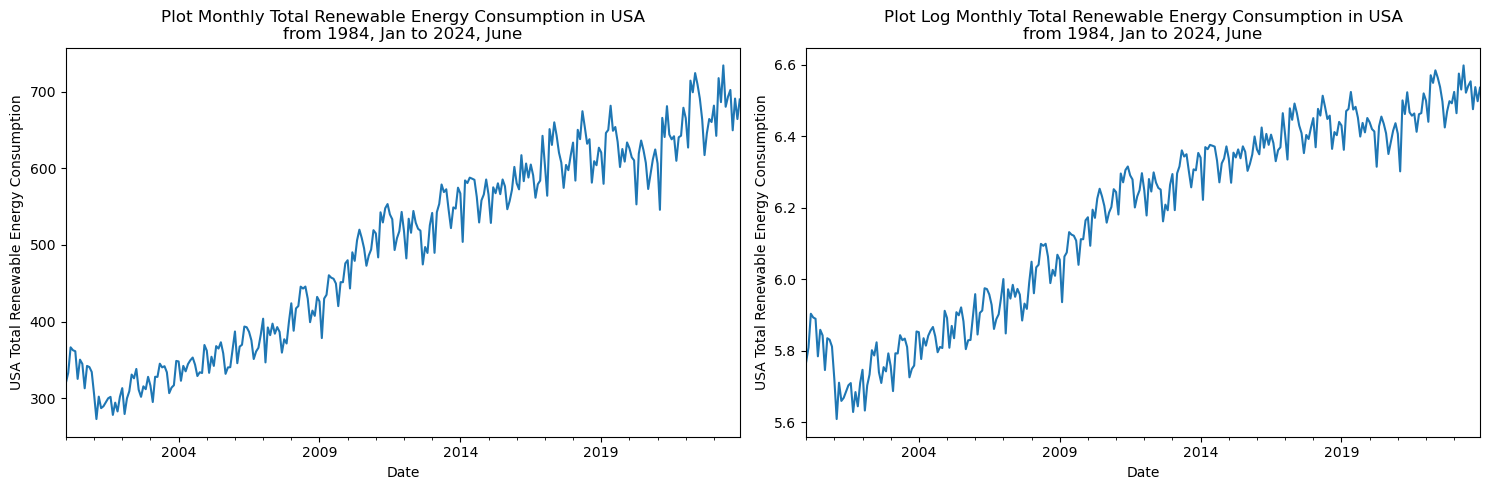

In [9]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 5))
renew.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption",
           title = "Plot Monthly Total Renewable Energy Consumption in USA\nfrom 1984, Jan to 2024, June", ax = ax[0])
np.log(renew).plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption",
                   title = "Plot Log Monthly Total Renewable Energy Consumption in USA\nfrom 1984, Jan to 2024, June", ax = ax[1])
plt.tight_layout()
plt.show()

2000-01-01    101.3445
2000-02-01     93.0799
2000-03-01    102.5932
2000-04-01    100.3152
2000-05-01    105.1063
2000-06-01    103.2447
2000-07-01    103.0562
2000-08-01    100.3669
2000-09-01     93.7955
2000-10-01     97.5586
2000-11-01     97.3796
2000-12-01    102.1594
Freq: MS, Name: seasonal, dtype: float64
Sum of seasonal variation: 100.0


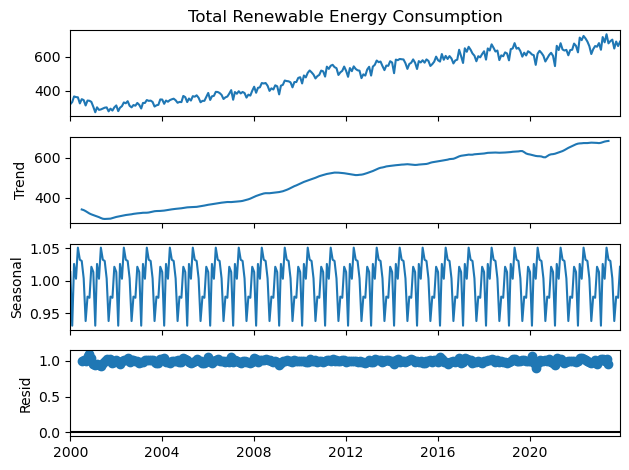

In [10]:
# Seasonal decompose
decom_mul = seasonal_decompose(renew, model = "mul", period = 12)
print(round(decom_mul.seasonal[:12] * 100, 4))
print("Sum of seasonal variation:", round(sum(decom_mul.seasonal[:12])/12, 4) * 100)

# Plot
decom_mul.plot()
plt.tight_layout()
plt.show()

In [11]:
# Seasonal decompose
decom_add = seasonal_decompose(renew, model = "add", period = 12)
round(pd.concat([decom_add.seasonal[:12], (decom_mul.seasonal[:12]) * 100], axis = 1), 4)

,seasonal,seasonal
2000-01-01,5.2187,101.3445
2000-02-01,-33.7851,93.0799
2000-03-01,14.9683,102.5932
2000-04-01,2.4681,100.3152
2000-05-01,26.6775,105.1063
2000-06-01,15.8397,103.2447
2000-07-01,13.6329,103.0562
2000-08-01,1.0234,100.3669
2000-09-01,-30.7397,93.7955
2000-10-01,-12.4842,97.5586


# Split data

In [12]:
size = 12
y_train = renew.iloc[:-size]
y_test = renew.iloc[-size:]

In [13]:
100 * len(y_train)/len(renew)

95.83333333333333

# Winter exponential smoothing

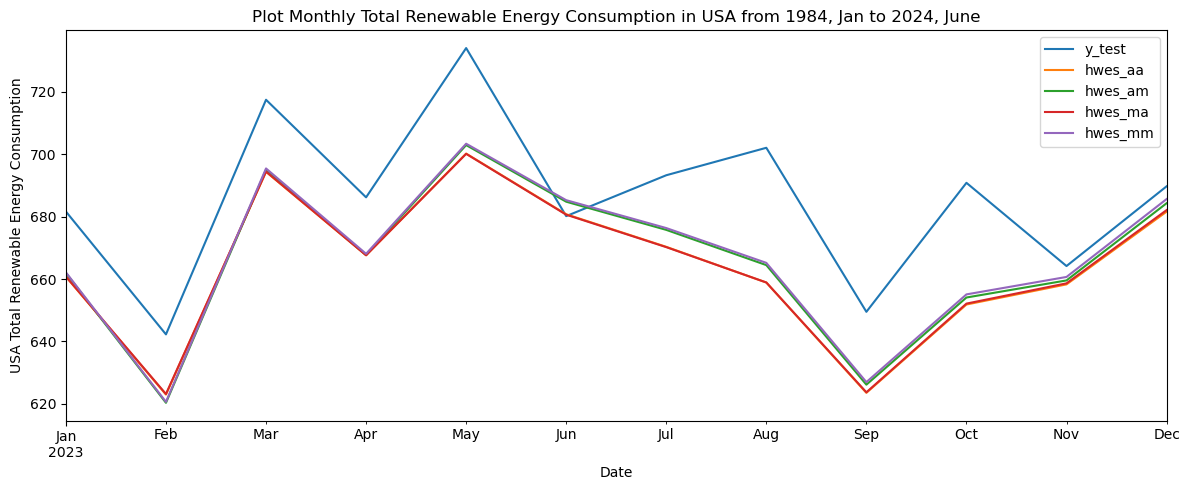

,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST,R2 TRAIN,R2 TEST
hwes_aa,2.4210,3.1574,233.9152,627.6909,98.5212,75.0875
hwes_am,2.3862,2.9455,228.0761,531.6733,98.5617,76.5496
hwes_ma,2.4626,3.1375,236.8991,623.6091,98.5075,74.9515
hwes_mm,2.4190,2.8624,230.1403,508.2403,98.5551,76.3201


In [14]:
hwes_aa = ExponentialSmoothing(y_train, trend = "add", seasonal = "add", seasonal_periods = 12, initialization_method = "legacy-heuristic").fit()
hwes_am = ExponentialSmoothing(y_train, trend = "add", seasonal = "mul", seasonal_periods = 12, initialization_method = "legacy-heuristic").fit()
hwes_ma = ExponentialSmoothing(y_train, trend = "mul", seasonal = "add", seasonal_periods = 12, initialization_method = "legacy-heuristic").fit()
hwes_mm = ExponentialSmoothing(y_train, trend = "mul", seasonal = "mul", seasonal_periods = 12, initialization_method = "legacy-heuristic").fit()

hwes = [hwes_aa, hwes_am, hwes_ma, hwes_mm]
hwes_name = "hwes_aa, hwes_am, hwes_ma, hwes_mm".split(", ")
# hwes = [hwes_aa, hwes_am]
# hwes_name = "hwes_aa, hwes_am".split(", ")
hwes_fit = pd.DataFrame(data = {"y_train": y_train})
hwes_forecast = pd.DataFrame(data = {"y_test": y_test})
for i, model in enumerate(hwes):
    hwes_fit[hwes_name[i]] = model.fittedvalues
    hwes_forecast[hwes_name[i]] = model.forecast(size)

hwes_forecast.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption", figsize = (12, 5),
                   title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2024, June")
plt.tight_layout()
plt.show()

hwes_evaluate = pd.DataFrame(index = hwes_forecast.columns[1:])
hwes_evaluate["MAPE TRAIN"] = [round(MAPE(hwes_fit["y_train"], hwes_fit[i]) * 100, 4) for i in hwes_forecast.columns[1:]]
hwes_evaluate["MAPE TEST"] = [round(MAPE(hwes_forecast["y_test"], hwes_forecast[i]) * 100, 4) for i in hwes_forecast.columns[1:]]
hwes_evaluate["RMSE TRAIN"] = [round(MSE(hwes_fit["y_train"], hwes_fit[i]), 4) for i in hwes_forecast.columns[1:]]
hwes_evaluate["RMSE TEST"] = [round(MSE(hwes_forecast["y_test"], hwes_forecast[i]), 4) for i in hwes_forecast.columns[1:]]
hwes_evaluate["R2 TRAIN"] = list(round(hwes_fit.corr().iloc[0, 1:] ** 2 * 100, 4))
hwes_evaluate["R2 TEST"] = list(round(hwes_forecast.corr().iloc[0, 1:] ** 2 * 100, 4))
hwes_evaluate

In [15]:
print(hwes_mm.summary())

                              ExponentialSmoothing Model Results                              
Dep. Variable:     Total Renewable Energy Consumption   No. Observations:                  276
Model:                           ExponentialSmoothing   SSE                          63518.724
Optimized:                                       True   AIC                           1533.078
Trend:                                 Multiplicative   BIC                           1591.005
Seasonal:                              Multiplicative   AICC                          1535.740
Seasonal Periods:                                  12   Date:                 Tue, 18 Feb 2025
Box-Cox:                                        False   Time:                         16:53:54
Box-Cox Coeff.:                                  None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------

In [16]:
print([round(i * 100, 2) for i in hwes_mm.params["initial_seasons"]])

[66.19, 68.89, 75.73, 74.95, 74.67, 67.23, 72.4, 71.28, 64.7, 70.72, 70.42, 69.09]


# SARIMA

## NoLog

In [17]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(y_train).keys()
df_adf['ADF D = 0'] = adf_test(y_train).values
df_adf['ADF D = 1'] = adf_test(y_train.diff(periods = 12).dropna()).values
df_adf['ADF D = 1, d = 1'] = adf_test(y_train.diff(periods = 12).diff().dropna()).values
df_adf['ADF D = 2'] = adf_test(y_train.diff(periods = 12).diff(periods = 12).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF D = 0,ADF D = 1,"ADF D = 1, d = 1",ADF D = 2
Test Statistic,-0.9338,-4.0094,-5.4738,-4.4593
p-value,0.7766,0.0014,0.0000,0.0002
Critical Value (1%),-3.4558,-3.4570,-3.4570,-3.4584
Critical Value (5%),-2.8727,-2.8733,-2.8733,-2.8739
Critical Value (10%),-2.5727,-2.5730,-2.5730,-2.5733


### Fitted

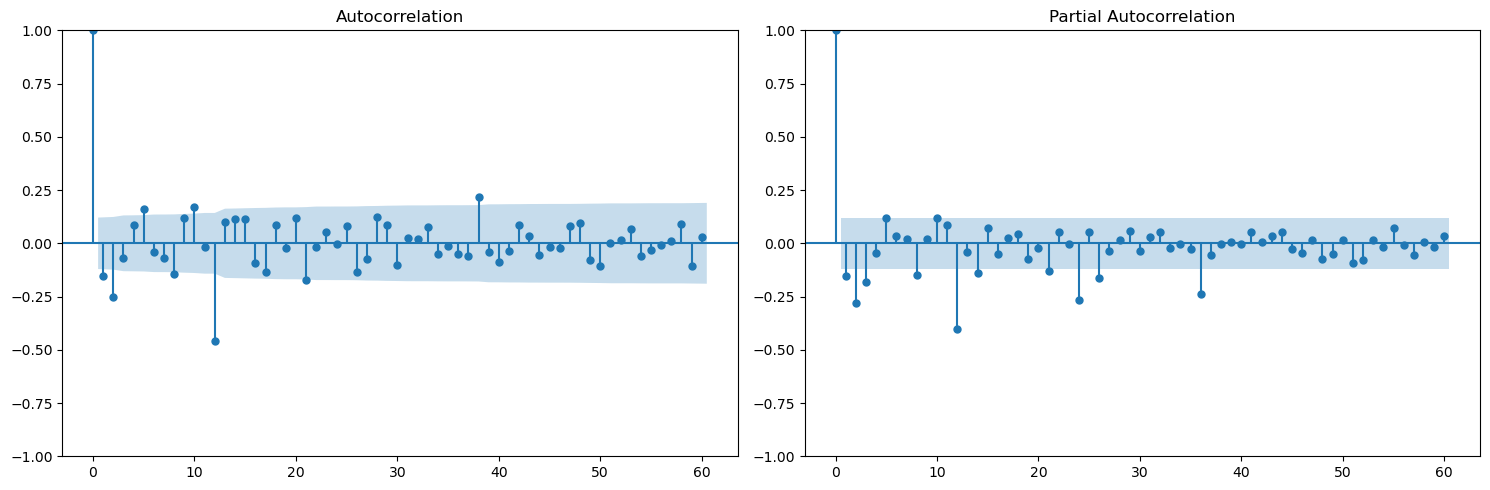

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_acf(y_train.diff(periods = 12).diff().dropna(), lags = 60, ax = ax[0])
plot_pacf(y_train.diff(periods = 12).diff().dropna(), lags = 60, ax = ax[1])
plt.tight_layout()
plt.show()

In [19]:
gridarima = auto_arima(y = y_train, D = 1, d = 1, m = 12, seasonal = True)
print(gridarima.summary())
# SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  276
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1067.380
Date:                                 Tue, 18 Feb 2025   AIC                           2150.760
Time:                                         16:54:22   BIC                           2179.337
Sample:                                     01-01-2000   HQIC                          2162.244
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1505      0.177      0.853      0.394      -0.195       0

In [20]:
adj_gridmodel = ARIMA(endog = y_train, order = ([2], 1, 1), seasonal_order = ([2], 1, 2, 12), concentrate_scale = True).fit()
print(adj_gridmodel.summary())

                                         SARIMAX Results                                         
Dep. Variable:        Total Renewable Energy Consumption   No. Observations:                  276
Model:             ARIMA([2], 1, 1)x([2], 1, [1, 2], 12)   Log Likelihood               -1068.506
Date:                                   Tue, 18 Feb 2025   AIC                           2149.013
Time:                                           16:54:23   BIC                           2170.446
Sample:                                       01-01-2000   HQIC                          2157.626
                                            - 12-01-2022   Scale                          188.621
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.2520      0.056     -4.530      0.000    

## Log

In [21]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(np.log(y_train)).keys()
df_adf['ADF D = 0'] = adf_test(np.log(y_train)).values
df_adf['ADF D = 1'] = adf_test(np.log(y_train).diff(periods = 12).dropna()).values
df_adf['ADF D = 1, d = 1'] = adf_test(np.log(y_train).diff(periods = 12).diff().dropna()).values
df_adf['ADF D = 2'] = adf_test(np.log(y_train).diff(periods = 12).diff(periods = 12).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF D = 0,ADF D = 1,"ADF D = 1, d = 1",ADF D = 2
Test Statistic,-1.3178,-4.2307,-6.6977,-4.6845
p-value,0.6210,0.0006,0.0000,0.0001
Critical Value (1%),-3.4557,-3.4567,-3.4569,-3.4580
Critical Value (5%),-2.8727,-2.8731,-2.8732,-2.8737
Critical Value (10%),-2.5727,-2.5729,-2.5730,-2.5733


### Fitted

In [22]:
# gridarima_ln = auto_arima(y = np.log(y_train), D = 1, d = 1, m = 12, seasonal = True)
# print(gridarima_ln.summary())
# # SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)

In [23]:
# adj_gridarima_ln = ARIMA(endog = np.log(y_train), order = ([2, 6, 8], 1, [1]), seasonal_order = (1, 1, 1, 12), concentrate_scale = True).fit() # MAPE = 2.3299
adj_gridarima_ln = ARIMA(endog = np.log(y_train), order = ([2], 1, 1), seasonal_order = (0, 1, 1, 12), concentrate_scale = True).fit()
print(adj_gridarima_ln.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Total Renewable Energy Consumption   No. Observations:                  276
Model:                 ARIMA([2], 1, 1)x(0, 1, 1, 12)   Log Likelihood                 554.448
Date:                                Tue, 18 Feb 2025   AIC                          -1100.896
Time:                                        16:54:23   BIC                          -1086.607
Sample:                                    01-01-2000   HQIC                         -1095.154
                                         - 12-01-2022   Scale                            0.001
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.2288      0.054     -4.211      0.000      -0.335      -0.122
ma.

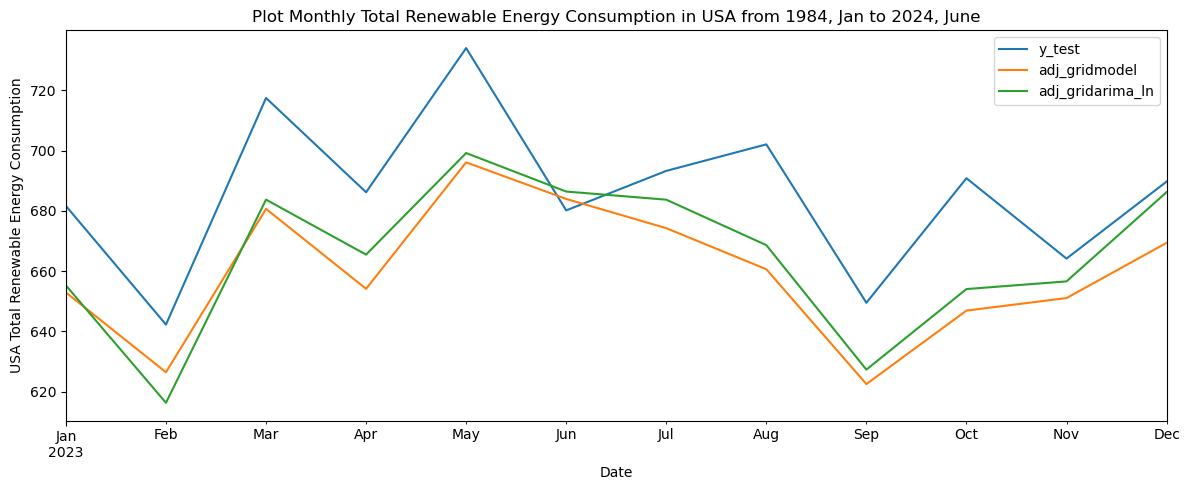

,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST,R2 TRAIN,R2 TEST
adj_gridmodel,2.2882,3.8598,205.4371,854.0632,98.6526,71.6787
adj_gridarima_ln,2.2424,3.1547,199.8697,610.4968,98.6999,72.0198


In [24]:
sarima = [adj_gridmodel, adj_gridarima_ln]
sarima_name = "adj_gridmodel, adj_gridarima_ln".split(", ")
sarima_fit = pd.DataFrame(data = {"y_train": y_train})
sarima_forecast = pd.DataFrame(data = {"y_test": y_test})
for i, model in enumerate(sarima):
    sarima_fit[sarima_name[i]] = model.fittedvalues
    sarima_forecast[sarima_name[i]] = model.forecast(size)

sarima_fit["adj_gridarima_ln"] = np.exp(sarima_fit["adj_gridarima_ln"])
sarima_forecast["adj_gridarima_ln"] = np.exp(sarima_forecast["adj_gridarima_ln"])
sarima_fit = sarima_fit[13:]

sarima_forecast.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption", figsize = (12, 5),
                   title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2024, June")
plt.tight_layout()
plt.show()

sarima_evaluate = pd.DataFrame(index = sarima_forecast.columns[1:])
sarima_evaluate["MAPE TRAIN"] = [round(MAPE(sarima_fit["y_train"], sarima_fit[i]) * 100, 4) for i in sarima_forecast.columns[1:]]
sarima_evaluate["MAPE TEST"] = [round(MAPE(sarima_forecast["y_test"], sarima_forecast[i]) * 100, 4) for i in sarima_forecast.columns[1:]]
sarima_evaluate["RMSE TRAIN"] = [round(MSE(sarima_fit["y_train"], sarima_fit[i]), 4) for i in sarima_forecast.columns[1:]]
sarima_evaluate["RMSE TEST"] = [round(MSE(sarima_forecast["y_test"], sarima_forecast[i]), 4) for i in sarima_forecast.columns[1:]]
sarima_evaluate["R2 TRAIN"] = list(round(sarima_fit.corr().iloc[0, 1:] ** 2 * 100, 4))
sarima_evaluate["R2 TEST"] = list(round(sarima_forecast.corr().iloc[0, 1:] ** 2 * 100, 4))
sarima_evaluate

### Assumption

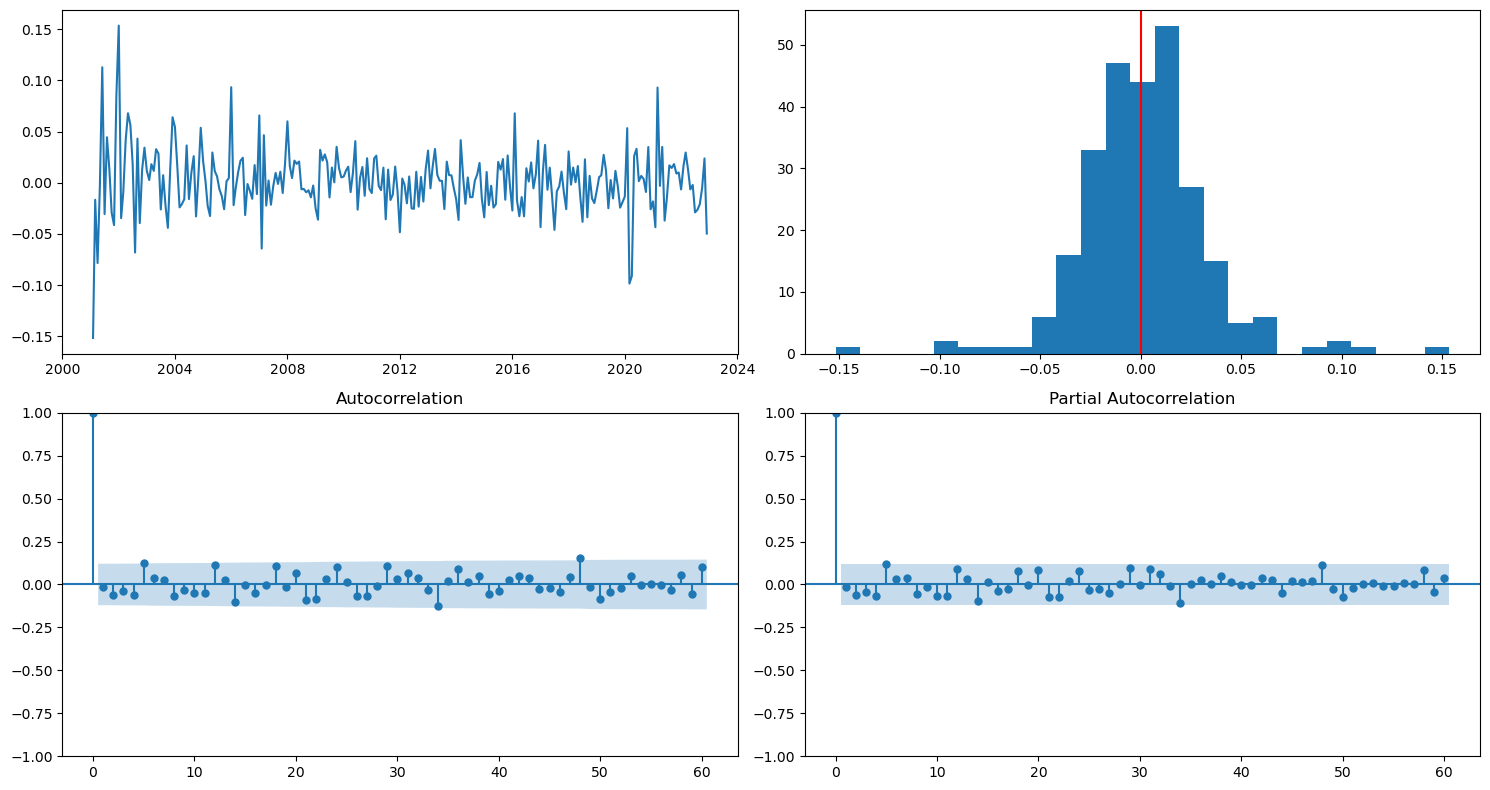

In [25]:
sarima_resid = adj_gridarima_ln.resid[13:]
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 8), facecolor = "w")
ax[0, 0].plot(sarima_resid)
ax[0, 1].hist(sarima_resid, bins = 25)
ax[0, 1].axvline(x = 0, color = "red")
plot_acf(sarima_resid, lags = 60, ax = ax[1, 0])
plot_pacf(sarima_resid, lags = 60, ax = ax[1, 1])
plt.tight_layout()
plt.show()

In [26]:
lag_idx = round(len(sarima_resid)/4, 0)
bj = acorr_ljungbox(sarima_resid, lags = lag_idx, return_df = True)
bj.tail().T

,62,63,64,65,66
lb_stat,69.671386,70.866750,70.898456,70.903524,70.904846
lb_pvalue,0.235237,0.231946,0.258630,0.287411,0.317575


In [27]:
t_stat, p_value = ttest_1samp(sarima_resid, 0)
print("T statistic:", round(t_stat, 2))
print("P-value:", round(p_value, 4))

T statistic: 0.86
P-value: 0.3897


In [28]:
# Test if data comes from a standard normal distribution
statistic, p_value = kstest(sarima_resid, 'norm', method = "asymp")

print(f"KS Statistic: {round(statistic, 4)}")
print(f"P-value: {round(p_value, 4)}")

# Interpretation
if p_value < 0.05:
    print("The sample does not follow the normal distribution.")
else:
    print("The sample follows the normal distribution.")

KS Statistic: 0.4576
P-value: 0.0
The sample does not follow the normal distribution.


# Import Exogenous variables

In [29]:
tmp_usa_gdp = pd.read_excel(r"Dataset/USA_GDP.xls", skiprows = 10)["NA000334Q"]
usa_gdp = []
for i in tmp_usa_gdp:
    usa_gdp = usa_gdp + ([i] * 3)

In [30]:
# Import Variables
# renew = pd.read_excel(r"Dataset/Renewable_Energy_Production_by_Source.xlsx", skiprows = 10)["Total Renewable Energy Consumption"][:-1]
oilprice = pd.read_csv(r"Dataset/ราคาย้อนหลังของ สัญญาซื้อขายล่วงหน้าน้ำมันดิบ WTI.csv")["ล่าสุด"]
fedfunds = pd.read_excel(r"Dataset/FEDFUNDS.xls", skiprows = 10)["FEDFUNDS"]

# contribute dataset
exog_df = pd.DataFrame(data = {"fedfunds": fedfunds, "usa_gdp": usa_gdp, "oilprice": oilprice})[:-6]
exog_df.index = pd.date_range(start = "1984-01", periods = len(exog_df), freq = "ME").to_period()
exog_df.index = exog_df.index.to_timestamp()
exog_df = exog_df.loc["2000-01-01":]
# exog_df["dm_month"] = exog_df.index.month.values
# exog_df = pd.concat([exog_df, pd.get_dummies(exog_df["dm_month"]).replace(to_replace = {True: 1, False: 0})], axis = 1)
# exog_df.drop(labels = "dm_month", axis = 1, inplace = True)
exog_df

,fedfunds,usa_gdp,oilprice
2000-01-01,5.45,2569266,27.64
2000-02-01,5.73,2569266,30.43
2000-03-01,5.85,2569266,26.90
2000-04-01,6.02,2577927,25.74
2000-05-01,6.27,2577927,29.01
...,...,...,...
2023-08-01,5.33,7159264,83.63
2023-09-01,5.33,7159264,90.79
2023-10-01,5.33,6997823,81.02
2023-11-01,5.33,6997823,75.96


In [31]:
adj_exog_df = pd.DataFrame()
for i in exog_df.columns:
    for j in range(1, 4):
        adj_exog_df[i + "_" + str(j)] = np.log(exog_df[i]) ** j
adj_exog_df

,fedfunds_1,fedfunds_2,fedfunds_3,usa_gdp_1,usa_gdp_2,usa_gdp_3,oilprice_1,oilprice_2,oilprice_3
2000-01-01,1.695616,2.875112,4.875085,14.759131,217.831942,3215.010132,3.319264,11.017513,36.570036
2000-02-01,1.745716,3.047523,5.320108,14.759131,217.831942,3215.010132,3.415429,11.665155,39.841508
2000-03-01,1.766442,3.120316,5.511856,14.759131,217.831942,3215.010132,3.292126,10.838095,35.680379
2000-04-01,1.795087,3.222338,5.784378,14.762496,217.931292,3217.209865,3.248046,10.549804,34.266251
2000-05-01,1.835776,3.370075,6.186704,14.762496,217.931292,3217.209865,3.367641,11.341003,38.192423
...,...,...,...,...,...,...,...,...,...
2023-08-01,1.673351,2.800104,4.685558,15.783918,249.132059,3932.279929,4.426402,19.593037,86.726666
2023-09-01,1.673351,2.800104,4.685558,15.783918,249.132059,3932.279929,4.508549,20.327015,91.645348
2023-10-01,1.673351,2.800104,4.685558,15.761110,248.412578,3915.257877,4.394696,19.313353,84.876317
2023-11-01,1.673351,2.800104,4.685558,15.761110,248.412578,3915.257877,4.330207,18.750692,81.194374


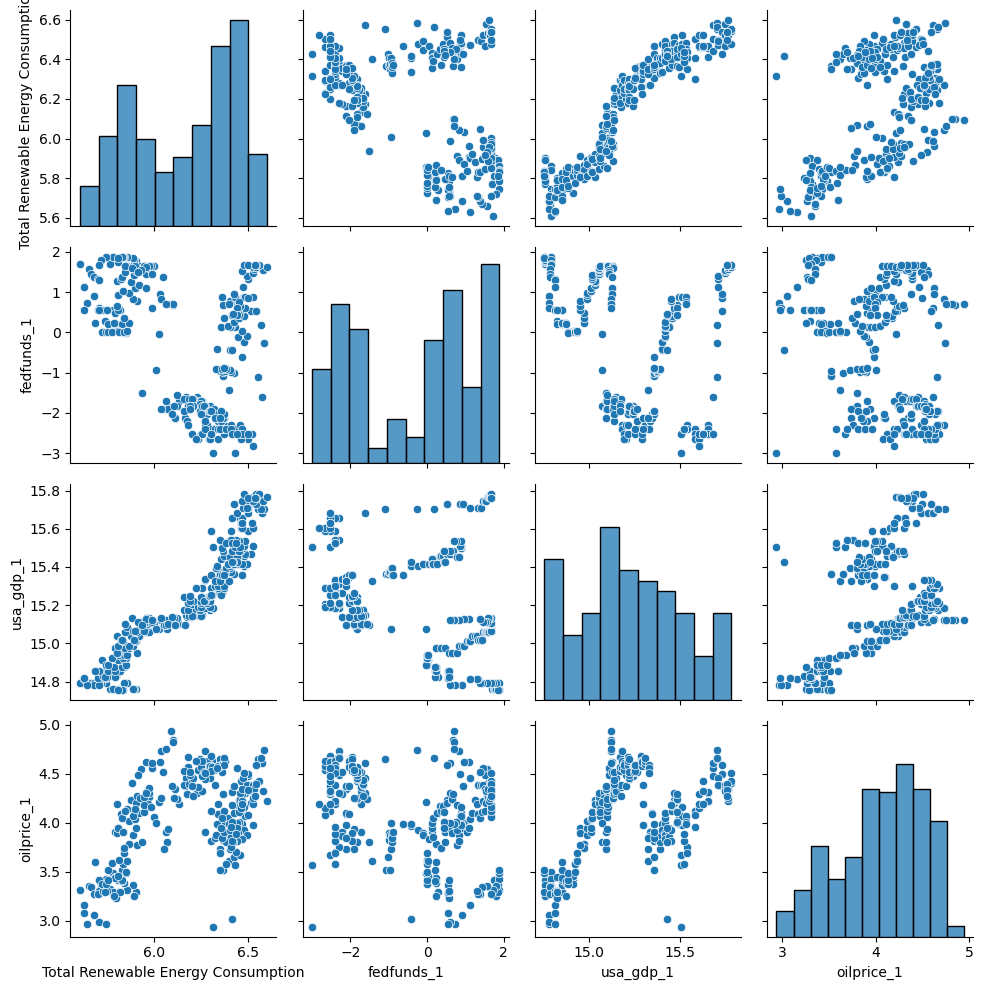

,Total Renewable Energy Consumption,fedfunds_1,usa_gdp_1,oilprice_1
Total Renewable Energy Consumption,1.0000,-0.4411,0.9366,0.5241
fedfunds_1,-0.4411,1.0000,-0.2865,-0.3195
usa_gdp_1,0.9366,-0.2865,1.0000,0.4938
oilprice_1,0.5241,-0.3195,0.4938,1.0000


In [32]:
full_df = pd.concat([np.log(renew), adj_exog_df], axis = 1)
# full_df = pd.DataFrame(StandardScaler().fit_transform(full_df), columns = full_df.columns, index = full_df.index)
sns.pairplot(full_df.iloc[:, [0, 1, 4, 7]])
plt.tight_layout()
plt.show()

round(full_df.iloc[:, [0, 1, 4, 7]].corr(), 4)

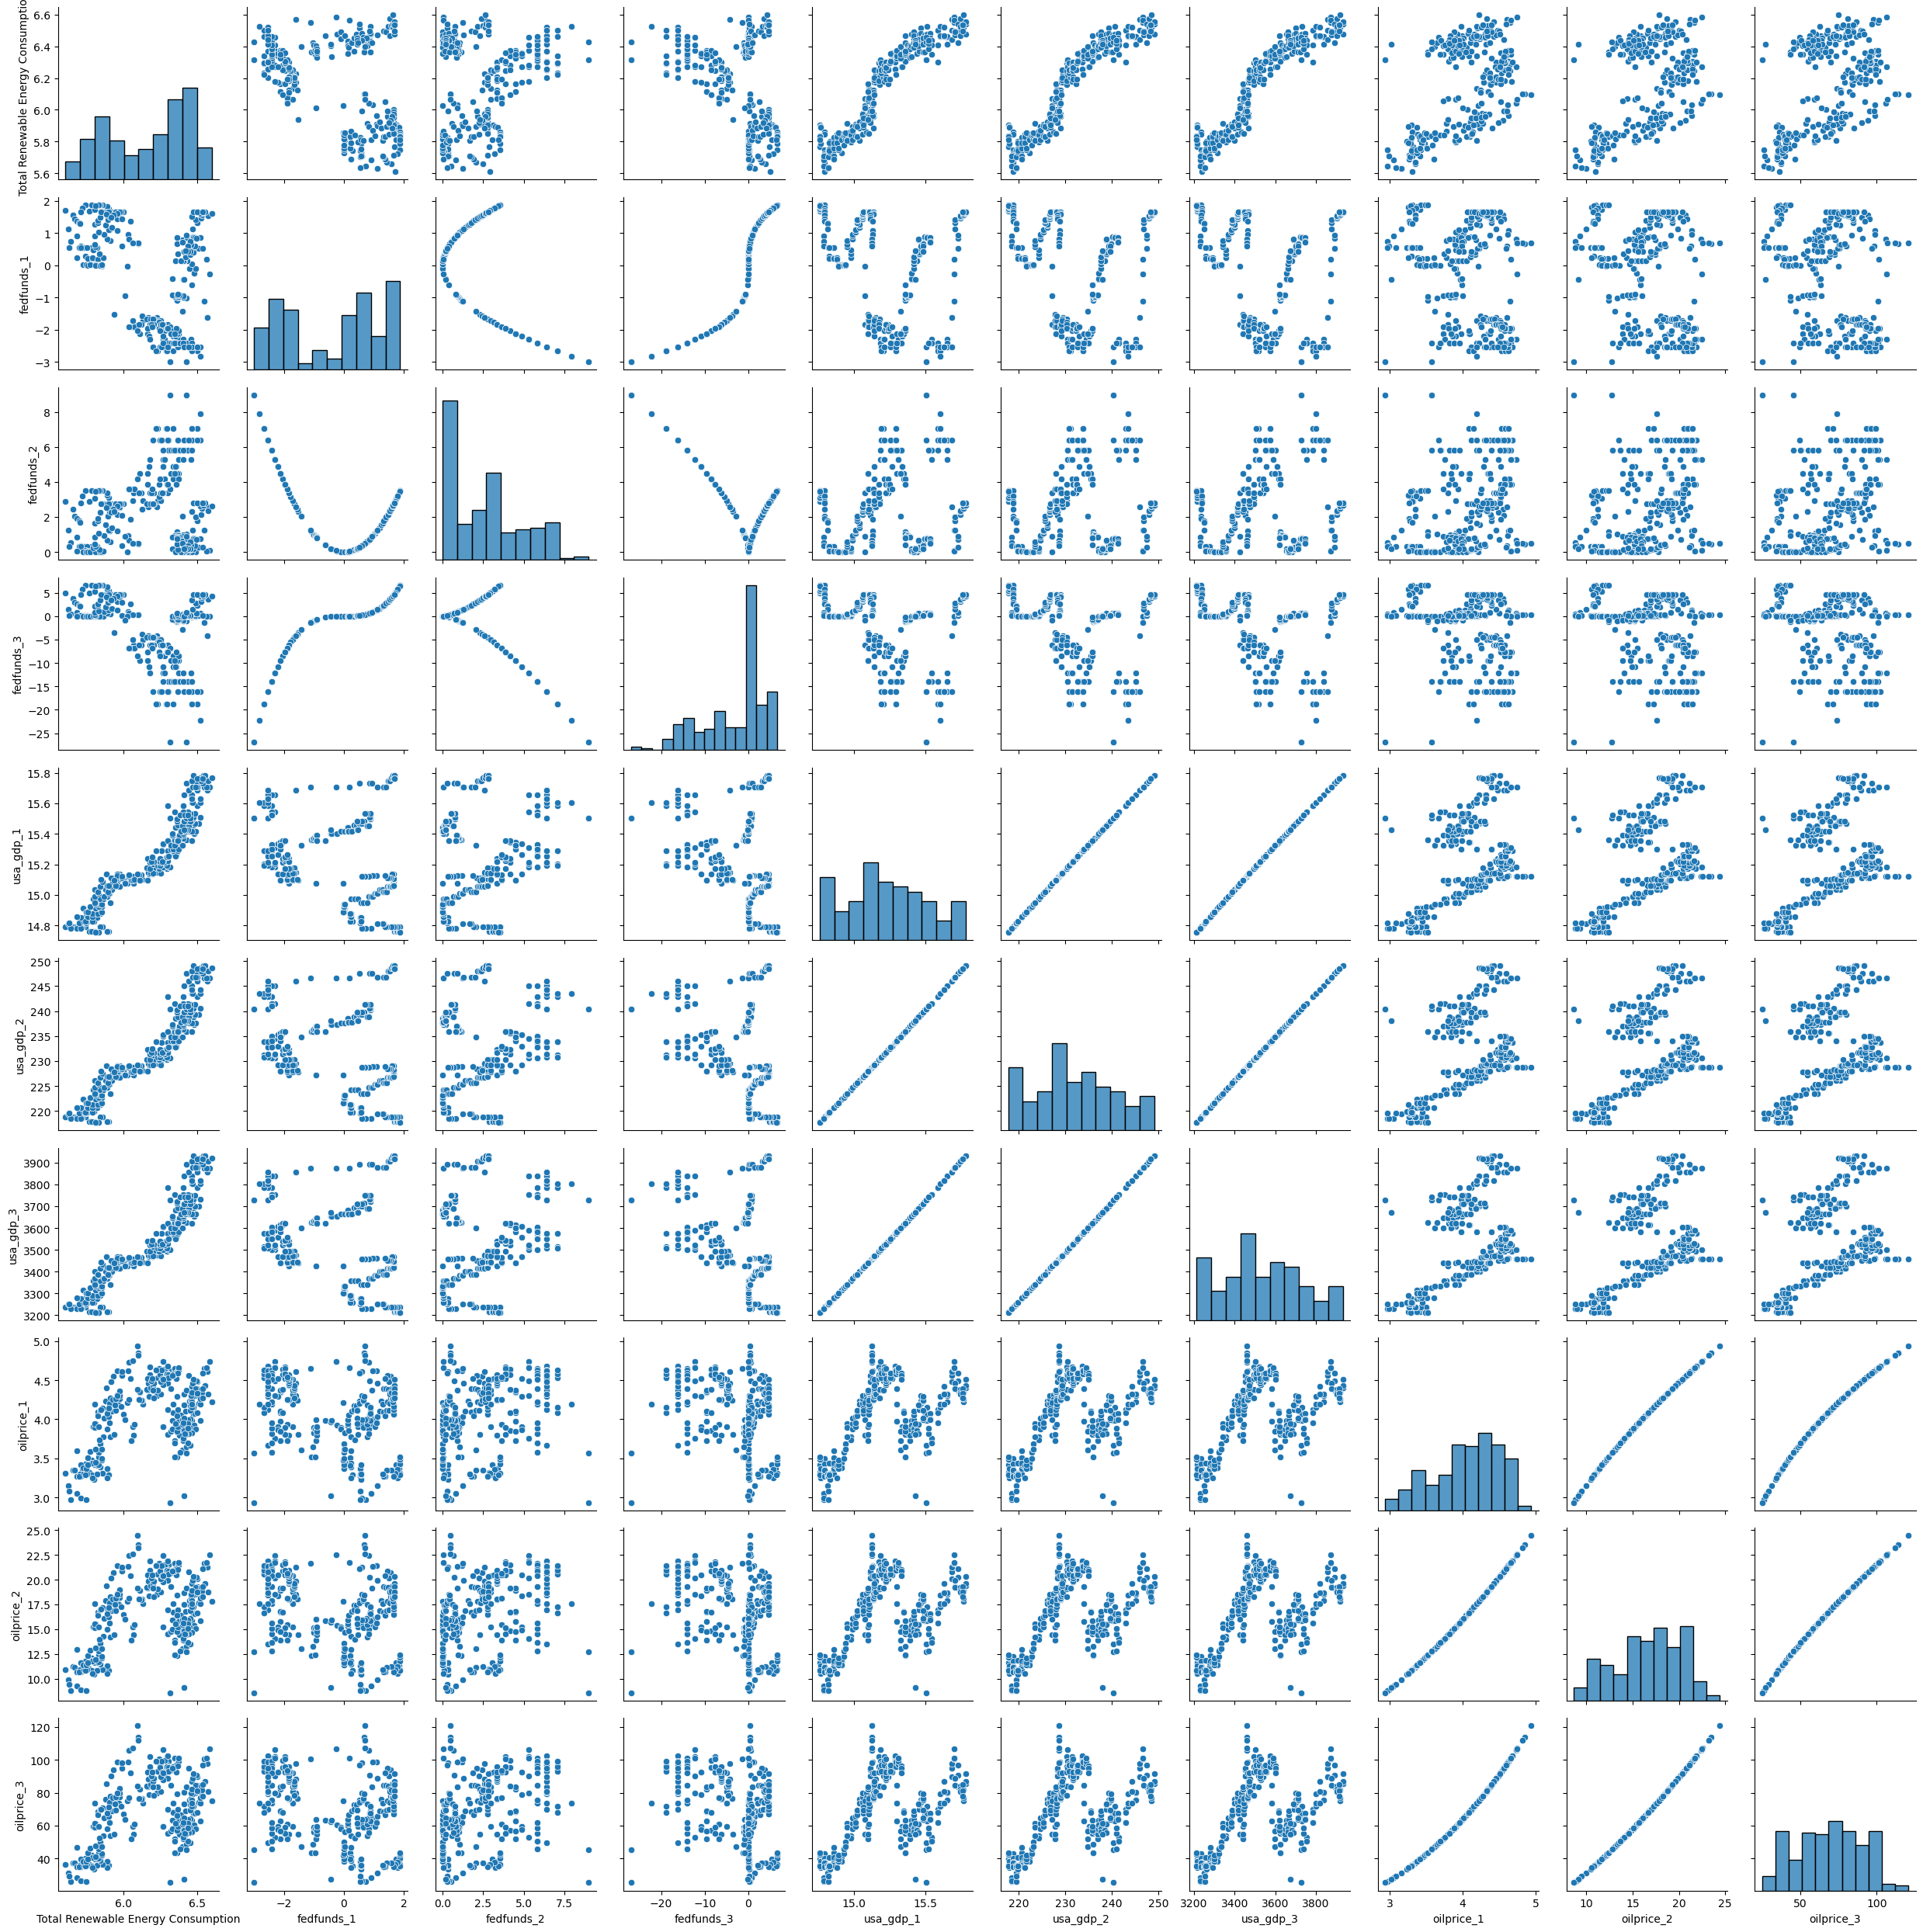

,Total Renewable Energy Consumption,fedfunds_1,fedfunds_2,fedfunds_3,usa_gdp_1,usa_gdp_2,usa_gdp_3,oilprice_1,oilprice_2,oilprice_3
Total Renewable Energy Consumption,1.0000,-0.4411,0.2930,-0.4248,0.9366,0.9349,0.9331,0.5241,0.5085,0.4913
fedfunds_1,-0.4411,1.0000,-0.6669,0.9290,-0.2865,-0.2817,-0.2770,-0.3195,-0.3217,-0.3227
fedfunds_2,0.2930,-0.6669,1.0000,-0.7961,0.2289,0.2272,0.2254,0.3536,0.3592,0.3628
fedfunds_3,-0.4248,0.9290,-0.7961,1.0000,-0.3205,-0.3168,-0.3131,-0.3271,-0.3331,-0.3375
usa_gdp_1,0.9366,-0.2865,0.2289,-0.3205,1.0000,1.0000,0.9998,0.4938,0.4761,0.4566
usa_gdp_2,0.9349,-0.2817,0.2272,-0.3168,1.0000,1.0000,1.0000,0.4896,0.4721,0.4527
usa_gdp_3,0.9331,-0.2770,0.2254,-0.3131,0.9998,1.0000,1.0000,0.4854,0.4680,0.4487
oilprice_1,0.5241,-0.3195,0.3536,-0.3271,0.4938,0.4896,0.4854,1.0000,0.9982,0.9931
oilprice_2,0.5085,-0.3217,0.3592,-0.3331,0.4761,0.4721,0.4680,0.9982,1.0000,0.9983
oilprice_3,0.4913,-0.3227,0.3628,-0.3375,0.4566,0.4527,0.4487,0.9931,0.9983,1.0000


In [33]:
full_df = pd.concat([np.log(renew), adj_exog_df], axis = 1)
# full_df = pd.DataFrame(StandardScaler().fit_transform(full_df), columns = full_df.columns, index = full_df.index)
sns.pairplot(full_df)
plt.tight_layout()
plt.show()

round(full_df.corr(), 4)

In [34]:
round(np.exp(full_df.iloc[:, [0, 1, 4, 7]]).describe(), 4)

,Total Renewable Energy Consumption,fedfunds_1,usa_gdp_1,oilprice_1
count,288.0000,288.0000,2.880000e+02,288.0000
mean,494.6252,1.7853,4.267110e+06,63.3803
std,128.0191,1.9504,1.206549e+06,25.7448
min,272.9990,0.0500,2.562488e+06,18.8400
25%,364.5252,0.1400,3.443084e+06,44.4000
50%,518.9455,1.0950,4.030726e+06,61.4550
75%,606.1565,2.6150,5.034204e+06,82.2425
max,734.0820,6.5400,7.159264e+06,140.0000


In [35]:
round(np.exp(full_df.iloc[:, [0, 7, 1, 4]]).corr(), 4)

,Total Renewable Energy Consumption,oilprice_1,fedfunds_1,usa_gdp_1
Total Renewable Energy Consumption,1.0000,0.4096,-0.3647,0.9224
oilprice_1,0.4096,1.0000,-0.2091,0.3589
fedfunds_1,-0.3647,-0.2091,1.0000,-0.1769
usa_gdp_1,0.9224,0.3589,-0.1769,1.0000


In [36]:
exog_train = full_df.iloc[: -size, 1:]
exog_test = full_df.iloc[-size:, 1:]

# Regression

## Original fitted

In [37]:
baseline_regr = OLS(endog = np.log(y_train), exog = add_constant(exog_train.iloc[:, [0, 3]])).fit()
print(baseline_regr.summary())

                                    OLS Regression Results                                    
Dep. Variable:     Total Renewable Energy Consumption   R-squared:                       0.905
Model:                                            OLS   Adj. R-squared:                  0.904
Method:                                 Least Squares   F-statistic:                     1295.
Date:                                Tue, 18 Feb 2025   Prob (F-statistic):          4.69e-140
Time:                                        16:54:29   Log-Likelihood:                 295.43
No. Observations:                                 276   AIC:                            -584.9
Df Residuals:                                     273   BIC:                            -574.0
Df Model:                                           2                                         
Covariance Type:                            nonrobust                                         
                 coef    std err          t      P

In [38]:
yyy_train = np.log(y_train)
xxx_train = exog_train.iloc[:, [0, 3]]
xxx_train["interaction"] = xxx_train["fedfunds_1"] * xxx_train["usa_gdp_1"]
xxx_train = add_constant(xxx_train)
interaction_regr = OLS(endog = yyy_train, exog = xxx_train).fit()
print(interaction_regr.summary())

xxx_test = exog_test.iloc[:, [0, 3]]
xxx_test["interaction"] = xxx_test["fedfunds_1"] * xxx_test["usa_gdp_1"]
xxx_test = add_constant(xxx_test)

interac_fitted = interaction_regr.fittedvalues
interac_forecast = interaction_regr.predict(xxx_test)

                                    OLS Regression Results                                    
Dep. Variable:     Total Renewable Energy Consumption   R-squared:                       0.912
Model:                                            OLS   Adj. R-squared:                  0.911
Method:                                 Least Squares   F-statistic:                     942.3
Date:                                Tue, 18 Feb 2025   Prob (F-statistic):          2.51e-143
Time:                                        16:54:29   Log-Likelihood:                 306.84
No. Observations:                                 276   AIC:                            -605.7
Df Residuals:                                     272   BIC:                            -591.2
Df Model:                                           3                                         
Covariance Type:                            nonrobust                                         
                  coef    std err          t      

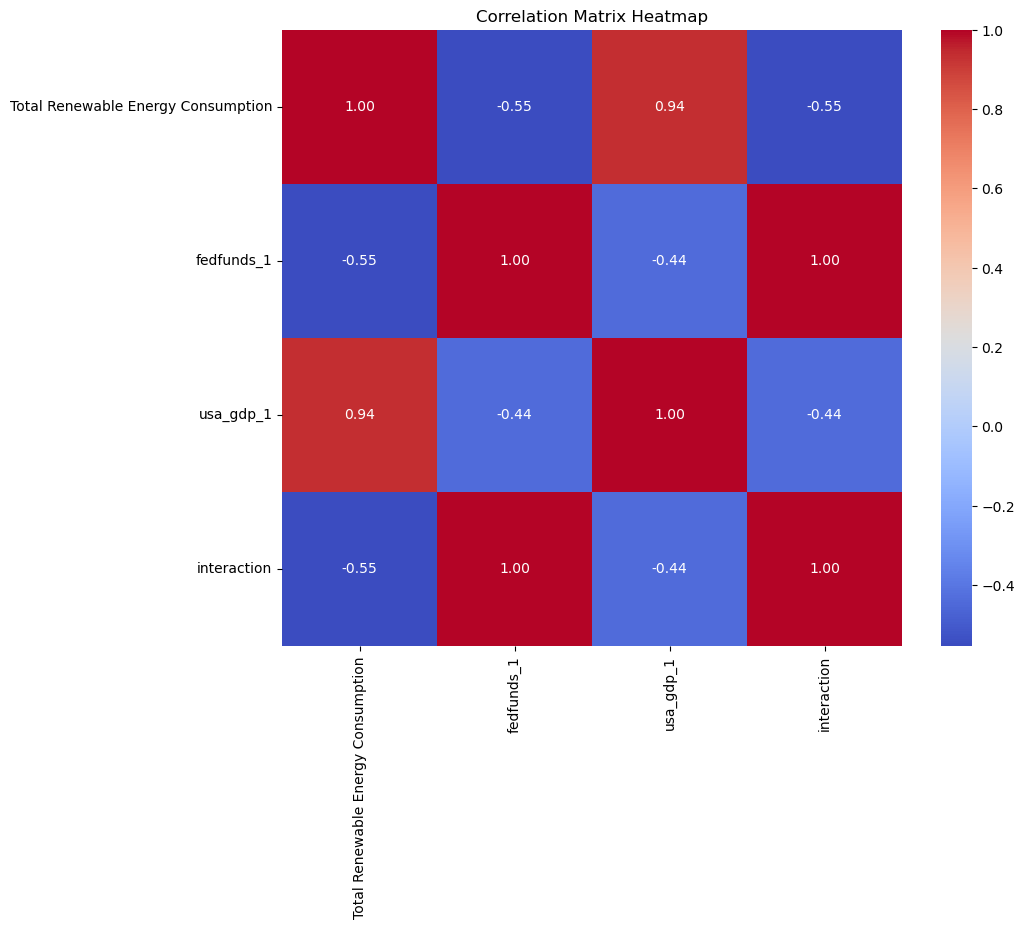

In [51]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = pd.concat([yyy_train, xxx_train.drop(columns="const")], axis=1).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Polynomial regression

In [39]:
regr = OLS(endog = np.log(y_train), exog = add_constant(exog_train.drop(labels = ["usa_gdp_2", "oilprice_1"], axis = 1))).fit()
print(regr.summary())

                                    OLS Regression Results                                    
Dep. Variable:     Total Renewable Energy Consumption   R-squared:                       0.922
Model:                                            OLS   Adj. R-squared:                  0.920
Method:                                 Least Squares   F-statistic:                     454.8
Date:                                Tue, 18 Feb 2025   Prob (F-statistic):          9.90e-145
Time:                                        16:54:29   Log-Likelihood:                 323.77
No. Observations:                                 276   AIC:                            -631.5
Df Residuals:                                     268   BIC:                            -602.6
Df Model:                                           7                                         
Covariance Type:                            nonrobust                                         
                 coef    std err          t      P

## Lasso regression

<Axes: xlabel='alpha'>

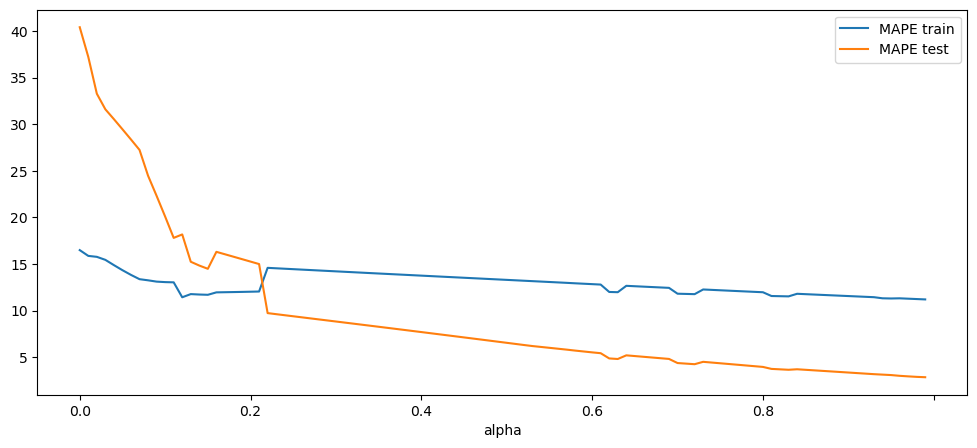

In [40]:
list_lasso_mape = []
for alpha in np.arange(0, 1, 0.01):
    lasso_regr = OLS(endog = np.log(y_train), exog = add_constant(exog_train)).fit_regularized(alpha = alpha)
    predict = np.exp(lasso_regr.fittedvalues)
    future = np.exp(lasso_regr.predict(add_constant(exog_test)))
    mape_train = MAPE(y_train, predict) * 100
    mape_test = MAPE(y_test, future) * 100
    list_lasso_mape.append({"alpha": str(round(alpha, 2)), "MAPE train": mape_train, "MAPE test": mape_test})
search_alpha = round(pd.DataFrame(list_lasso_mape), 4)
search_alpha.index = search_alpha["alpha"]
search_alpha.drop("alpha", axis = 1, inplace = True)
search_alpha.plot(figsize = (12, 5))
# plt.axvline(x = 10, color = "red")
# plt.axvline(x = 11, color = "red")

In [41]:
lasso_regr = OLS(endog = np.log(y_train), exog = add_constant(exog_train)).fit_regularized(alpha = 0.1)
lasso_regr.params[lasso_regr.params != 0]

const         0.760751
fedfunds_2    0.026116
fedfunds_3   -0.010453
usa_gdp_1     0.307790
usa_gdp_2     0.001818
usa_gdp_3     0.000038
oilprice_3    0.000828
dtype: float64

## Evaluate regression

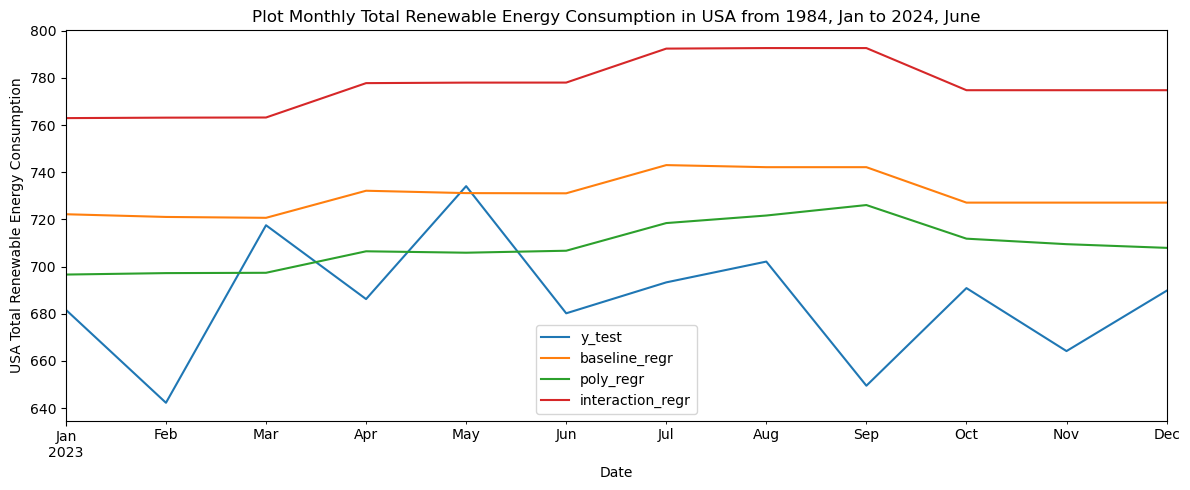

,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST,R2 TRAIN,R2 TEST
baseline_regr,6.8585,6.7085,1869.3217,2657.6931,88.0744,0.0841
poly_regr,5.9074,4.5795,1325.9688,1272.1244,91.3813,1.1135
interaction_regr,6.3724,13.4301,1458.2827,9015.1304,90.5426,0.0964


In [43]:
# regression = [baseline_regr, regr, lasso_regr]
regression = [baseline_regr, regr, interaction_regr]
# regression_name = "baseline_regr, poly_regr, lasso_regr".split(", ")
regression_name = "baseline_regr, poly_regr, interaction_regr".split(", ")
regression_fit = pd.DataFrame(data = {"y_train": y_train})
regression_forecast = pd.DataFrame(data = {"y_test": y_test})
for i, model in enumerate(regression):
    regression_fit[regression_name[i]] = np.exp(model.fittedvalues)

regression_forecast["baseline_regr"] = np.exp(baseline_regr.predict(add_constant(exog_test.iloc[:, [0, 3]])))
regression_forecast["poly_regr"] = np.exp(regr.predict(add_constant(exog_test.drop(labels = ["usa_gdp_2", "oilprice_1"], axis = 1))))
regression_forecast["interaction_regr"] = np.exp(interac_forecast)
# regression_forecast["lasso_regr"] = np.exp(lasso_regr.predict(exog = add_constant(exog_test)))

regression_forecast.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption", figsize = (12, 5),
                   title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2024, June")
plt.tight_layout()
plt.show()

regression_evaluate = pd.DataFrame(index = regression_forecast.columns[1:])
regression_evaluate["MAPE TRAIN"] = [round(MAPE(regression_fit["y_train"], regression_fit[i]) * 100, 4) for i in regression_forecast.columns[1:]]
regression_evaluate["MAPE TEST"] = [round(MAPE(regression_forecast["y_test"], regression_forecast[i]) * 100, 4) for i in regression_forecast.columns[1:]]
regression_evaluate["RMSE TRAIN"] = [round(MSE(regression_fit["y_train"], regression_fit[i]), 4) for i in regression_forecast.columns[1:]]
regression_evaluate["RMSE TEST"] = [round(MSE(regression_forecast["y_test"], regression_forecast[i]), 4) for i in regression_forecast.columns[1:]]
regression_evaluate["R2 TRAIN"] = list(round(regression_fit.corr().iloc[0, 1:] ** 2 * 100, 4))
regression_evaluate["R2 TEST"] = list(round(regression_forecast.corr().iloc[0, 1:] ** 2 * 100, 4))
regression_evaluate

# Regression SARIMA

## Regression Residual

In [ ]:
resid = regr.resid

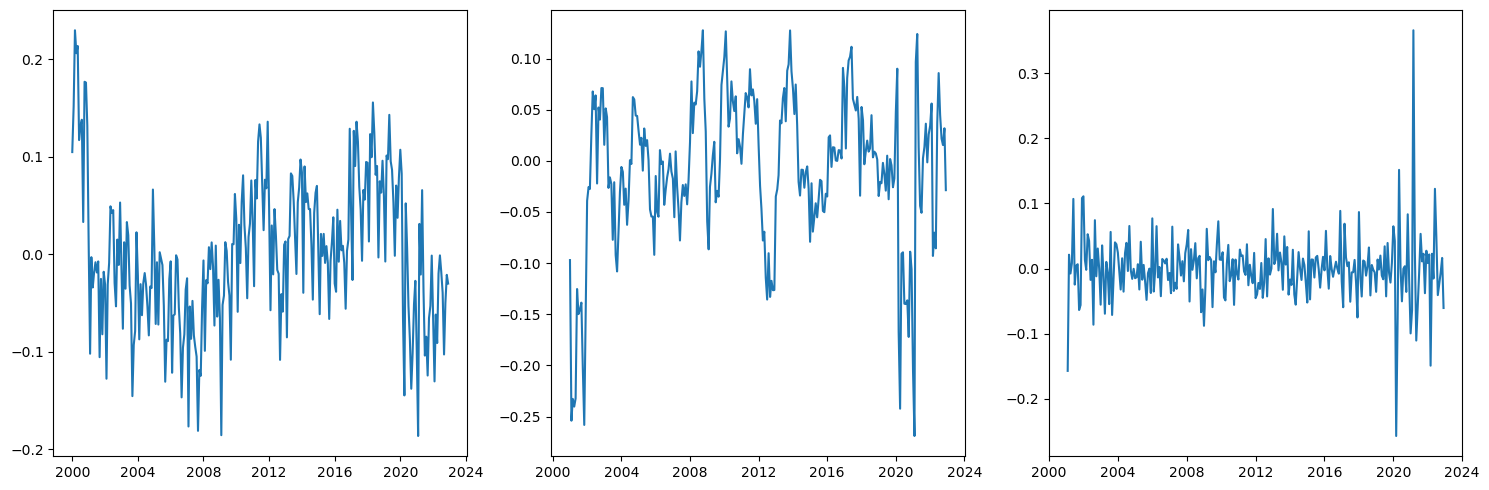

In [ ]:
fig, ax = plt.subplots(ncols = 3, facecolor = "w", figsize = (15, 5))
ax[0].plot(resid)
ax[1].plot(resid.diff(periods = 12))
ax[2].plot(resid.diff(periods = 12).diff())
plt.tight_layout()
plt.show()

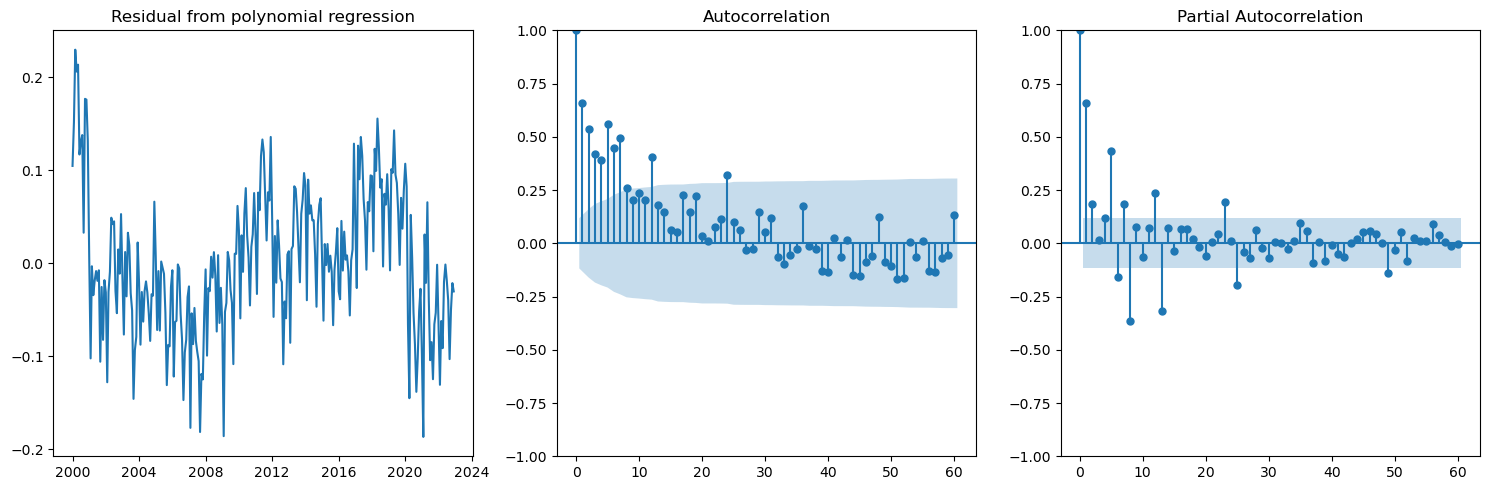

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = 'w')

# Seasonal differencing order 0
axes[0].plot(resid.dropna())
axes[0].set_title('Residual from polynomial regression')
plot_acf(resid.dropna(), ax = axes[1], lags = 60)
plot_pacf(resid.dropna(), ax = axes[2], lags = 60)
plt.tight_layout()
plt.show()

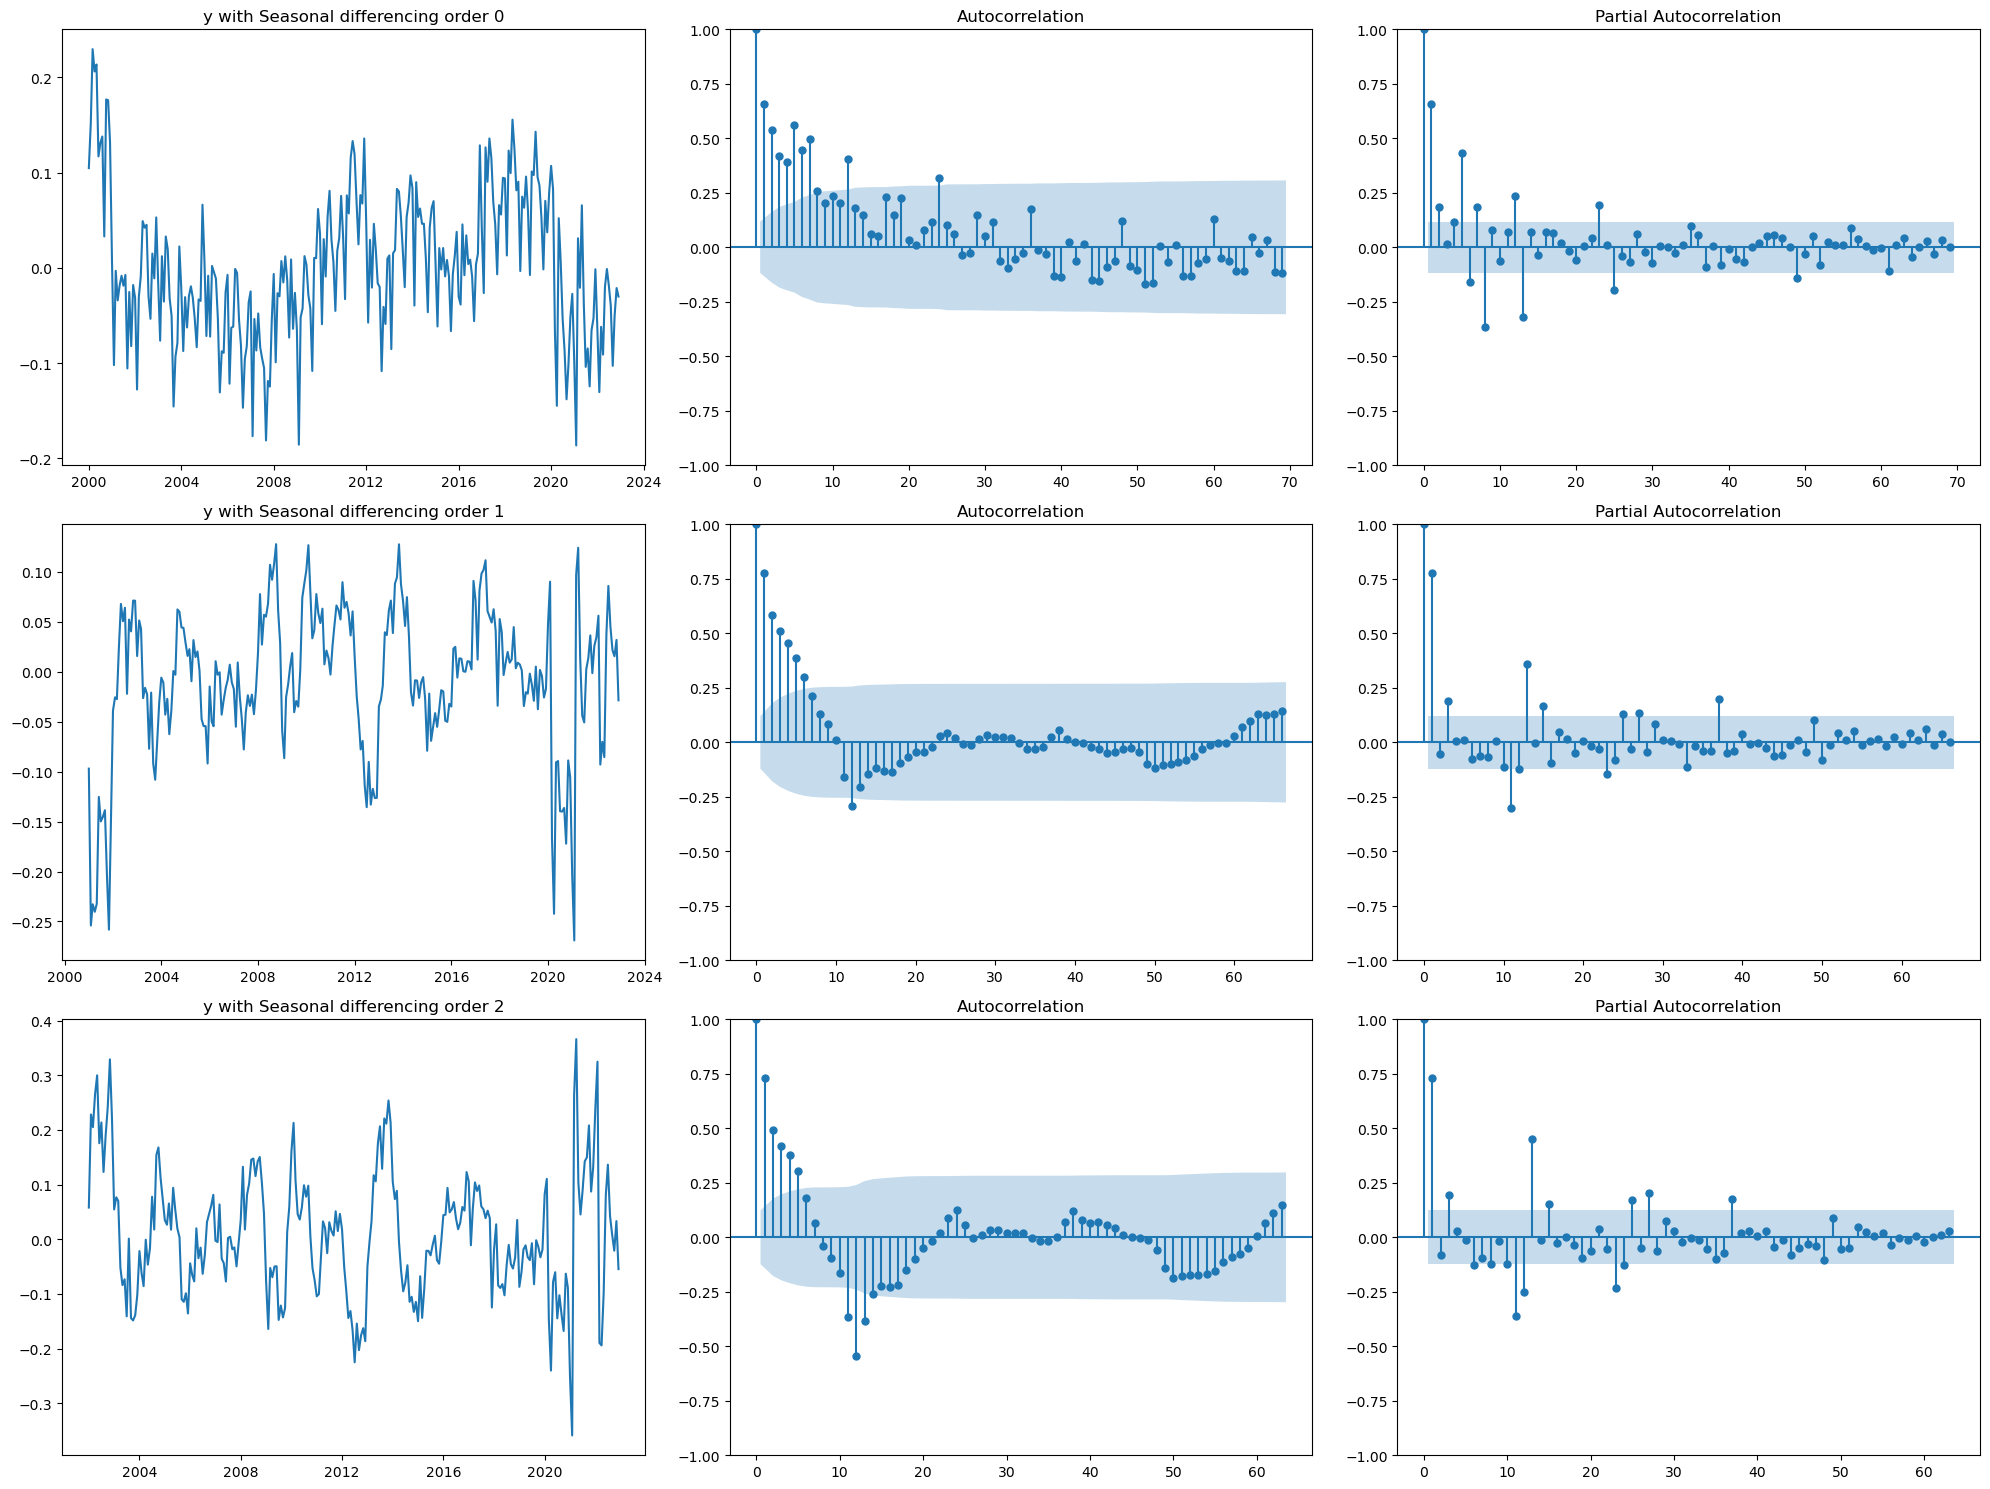

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15), facecolor = 'w')

# Seasonal differencing order 0
axes[0, 0].plot(resid.dropna())
axes[0, 0].set_title('y with Seasonal differencing order 0')
plot_acf(resid.dropna(), ax = axes[0, 1], lags = round(len(resid)/4))
plot_pacf(resid.dropna(), ax = axes[0, 2], lags = round(len(resid)/4))

# Seasonal differencing order 1
axes[1, 0].plot(resid.diff(periods = 12).dropna())
axes[1, 0].set_title('y with Seasonal differencing order 1')
plot_acf(resid.diff(periods = 12).dropna(), ax = axes[1, 1], lags = round(len(resid.diff(periods = 12).dropna())/4))
plot_pacf(resid.diff(periods = 12).dropna(), ax = axes[1, 2], lags = round(len(resid.diff(periods = 12).dropna())/4))

# Seasonal differencing order 2
axes[2, 0].plot(resid.diff(periods = 12).diff(periods = 12).dropna())
axes[2, 0].set_title('y with Seasonal differencing order 2')
plot_acf(resid.diff(periods = 12).diff(periods = 12).dropna(), ax = axes[2, 1], lags = round(len(resid.diff(periods = 12).diff(periods = 12).dropna())/4))
plot_pacf(resid.diff(periods = 12).diff(periods = 12).dropna(), ax = axes[2, 2], lags = round(len(resid.diff(periods = 12).diff(periods = 12).dropna())/4))

plt.tight_layout()
plt.show()

In [ ]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(resid).keys()
df_adf['ADF D = 0'] = adf_test(resid).values
df_adf['ADF D = 1'] = adf_test(resid.diff(periods = 12).dropna()).values
df_adf['ADF D = 1, d = 1'] = adf_test(resid.diff(periods = 12).diff().dropna()).values
df_adf['ADF D = 2'] = adf_test(resid.diff(periods = 12).diff(periods = 12).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF D = 0,ADF D = 1,"ADF D = 1, d = 1",ADF D = 2
Test Statistic,-3.2851,-3.8293,-8.0579,-4.3202
p-value,0.0156,0.0026,0.0000,0.0004
Critical Value (1%),-3.4555,-3.4570,-3.4569,-3.4584
Critical Value (5%),-2.8726,-2.8733,-2.8732,-2.8739
Critical Value (10%),-2.5727,-2.5730,-2.5730,-2.5733


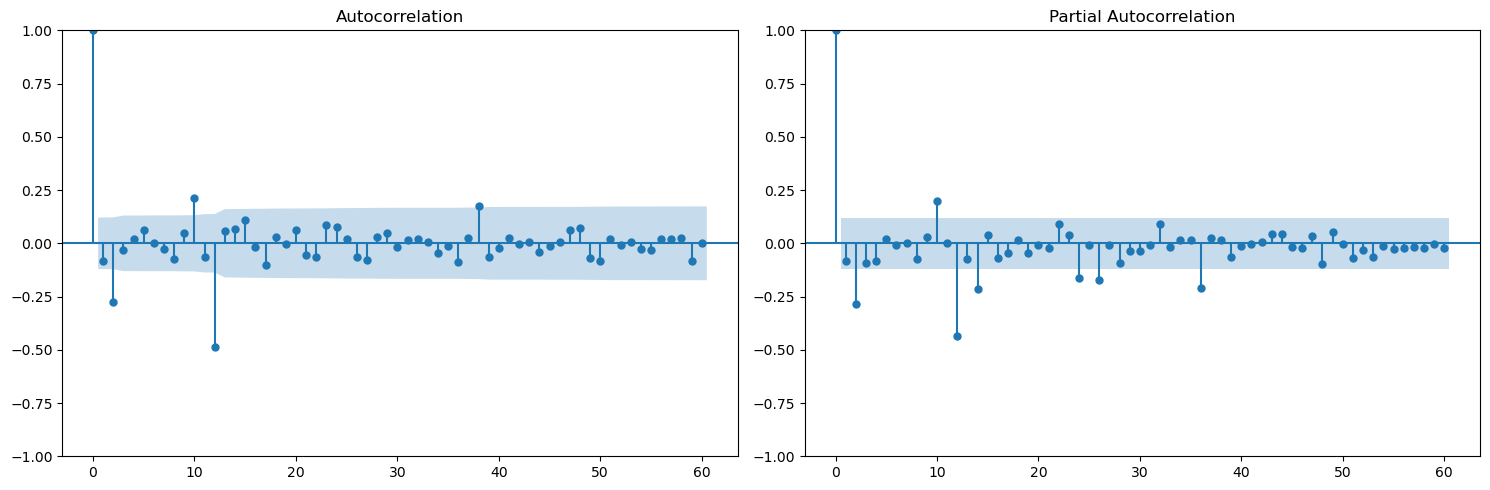

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_acf(resid.diff(periods = 12).diff().dropna(), lags = 60, ax = ax[0])
plot_pacf(resid.diff(periods = 12).diff().dropna(), lags = 60, ax = ax[1])
plt.tight_layout()
plt.show()

## Fitted model

In [ ]:
# gridarima_res = auto_arima(y = resid, D = 1, d = 1, m = 12, seasonal = True)
# print(gridarima_res.summary())
# # SARIMAX(2, 1, 1)x(2, 1, 0, 12)

In [ ]:
# gridarima_res = auto_arima(y = resid, D = 1, d = 0, m = 12, seasonal = True)
# print(gridarima_res.summary())
# # SARIMAX(2, 0, 2)x(1, 1, [1], 12)

In [ ]:
sarima_res = ARIMA(endog = resid, order = ([1], 1, [1]), seasonal_order = (2, 1, 0, 12), concentrate_scale = True).fit()
print(sarima_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  276
Model:             ARIMA(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                 481.805
Date:                           Tue, 18 Feb 2025   AIC                           -953.611
Time:                                   16:12:12   BIC                           -935.750
Sample:                               01-01-2000   HQIC                          -946.433
                                    - 12-01-2022   Scale                            0.001
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4487      0.116      3.854      0.000       0.221       0.677
ma.L1         -0.7284      0.108     -6.758

In [ ]:
# sarima_res.summary()

In [ ]:
# sarima_res = ARIMA(endog = resid, order = ([1, 6], 2, 3), seasonal_order = (0, 1, 1, 12), concentrate_scale = True).fit()
# print(sarima_res.summary())

## Evaluate model

In [ ]:
sarimax_fitted = np.exp(regr.fittedvalues + sarima_res.fittedvalues)
sarimax_forecast = np.exp(regr.predict(add_constant(exog_test.drop(labels = ["usa_gdp_2", "oilprice_1"], axis = 1))) + sarima_res.forecast(size))
sarimax_resid = y_train - sarimax_fitted

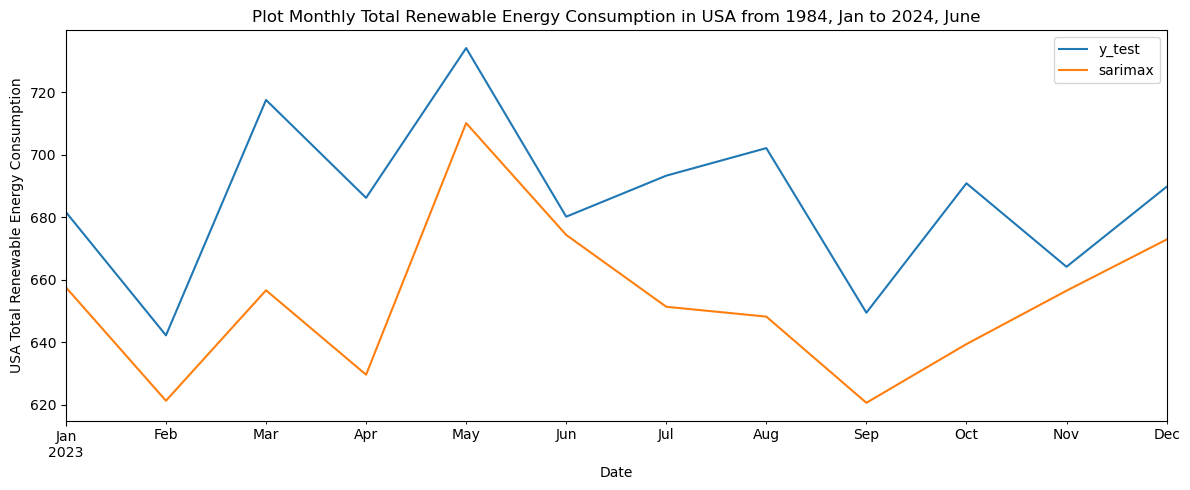

,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST,R2 TRAIN,R2 TEST
sarimax,2.7613,4.7353,422.9239,1416.812,97.2389,50.6927


In [ ]:
df_sarimax_fit = pd.DataFrame(data = {"y_train": y_train[14:], "sarimax": sarimax_fitted[14:]})
df_sarimax_forecast = pd.DataFrame(data = {"y_test": y_test, "sarimax": sarimax_forecast})

df_sarimax_forecast.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption", figsize = (12, 5),
                   title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2024, June")
plt.tight_layout()
plt.show()

sarimax_evaluate = pd.DataFrame(index = df_sarimax_forecast.columns[1:])
sarimax_evaluate["MAPE TRAIN"] = [round(MAPE(df_sarimax_fit["y_train"], df_sarimax_fit[i]) * 100, 4) for i in df_sarimax_forecast.columns[1:]]
sarimax_evaluate["MAPE TEST"] = [round(MAPE(df_sarimax_forecast["y_test"], df_sarimax_forecast[i]) * 100, 4) for i in df_sarimax_forecast.columns[1:]]
sarimax_evaluate["RMSE TRAIN"] = [round(MSE(df_sarimax_fit["y_train"], df_sarimax_fit[i]), 4) for i in df_sarimax_forecast.columns[1:]]
sarimax_evaluate["RMSE TEST"] = [round(MSE(df_sarimax_forecast["y_test"], df_sarimax_forecast[i]), 4) for i in df_sarimax_forecast.columns[1:]]
sarimax_evaluate["R2 TRAIN"] = list(round(df_sarimax_fit.corr().iloc[0, 1:] ** 2 * 100, 4))
sarimax_evaluate["R2 TEST"] = list(round(df_sarimax_forecast.corr().iloc[0, 1:] ** 2 * 100, 4))
sarimax_evaluate

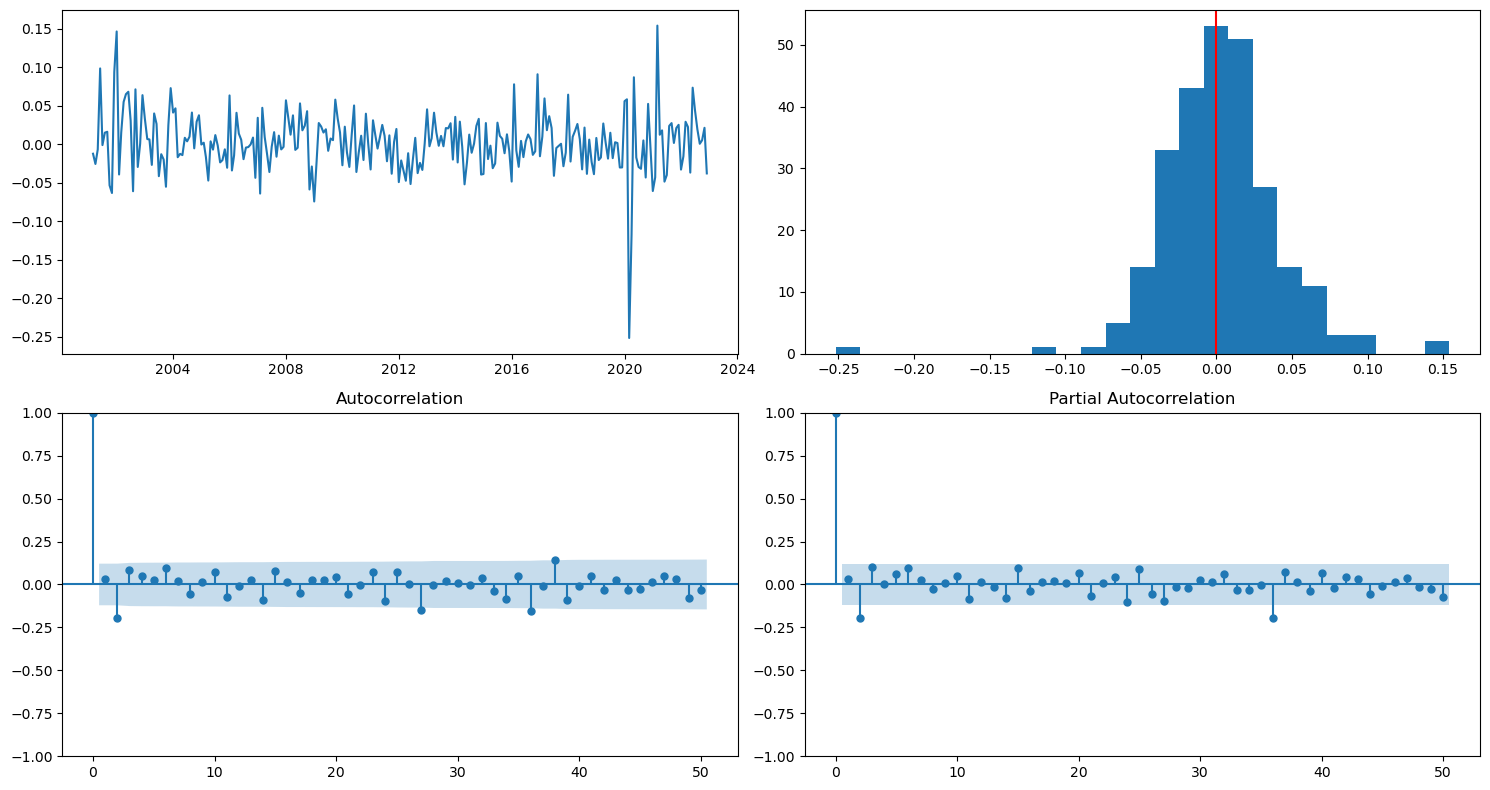

In [ ]:
sarimax_resid = sarima_res.resid[14:]
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 8), facecolor = "w")
ax[0, 0].plot(sarimax_resid)
ax[0, 1].hist(sarimax_resid, bins = 25)
ax[0, 1].axvline(x = 0, color = "red")
plot_acf(sarimax_resid, lags = 50, ax = ax[1, 0])
plot_pacf(sarimax_resid, lags = 50, ax = ax[1, 1])
plt.tight_layout()
plt.show()

## Assumption

In [ ]:
lag_idx = round(len(sarimax_resid)/4, 0)
bj = acorr_ljungbox(sarimax_resid, lags = lag_idx, return_df = True)
bj.tail().T

,62,63,64,65,66
lb_stat,69.821523,77.424834,78.083515,79.261522,79.550972
lb_pvalue,0.231424,0.104433,0.110920,0.109906,0.122142


In [ ]:
t_stat, p_value = ttest_1samp(sarimax_resid, 0)
print("T statistic:", round(t_stat, 2))
print("P-value:", round(p_value, 4))

T statistic: 0.9
P-value: 0.3689


In [ ]:
# Test if data comes from a standard normal distribution
statistic, p_value = kstest(sarimax_resid, 'norm', method = "asymp")

print(f"KS Statistic: {round(statistic, 4)}")
print(f"P-value: {round(p_value, 4)}")

# Interpretation
if p_value < 0.05:
    print("The sample does not follow the normal distribution.")
else:
    print("The sample follows the normal distribution.")

KS Statistic: 0.463
P-value: 0.0
The sample does not follow the normal distribution.


# SARIMAX

In [ ]:
# gridsarimax = auto_arima(y = np.log(y_train), X = exog_train.iloc[:, [6]], D = 1, d = 2, m = 12, seasonal = True, concentrate_scale = True)
# print(gridsarimax.summary())

In [ ]:
# hy_sarimax = ARIMA(endog = np.log(y_train), exog = exog_train.iloc[:, [6]],
#                    order = (2, 0, 2), seasonal_order = (0, 1, 1, 12), concentrate_scale = True).fit()
# print(hy_sarimax.summary())
# hy_sarimax_fitted = np.exp(hy_sarimax.fittedvalues)
# hy_sarimax_forecast = np.exp(hy_sarimax.forecast(steps = size, exog = exog_test.iloc[:, [6]]))

In [ ]:
# df_hy_sarimax_fit = pd.DataFrame(data = {"y_train": y_train[12:], "sarimax": hy_sarimax_fitted[12:]})
# df_hy_sarimax_forecast = pd.DataFrame(data = {"y_test": y_test, "sarimax": hy_sarimax_forecast})

# df_hy_sarimax_forecast.plot(xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption", figsize = (12, 5),
#                    title = "Plot Monthly Total Renewable Energy Consumption in USA from 1984, Jan to 2024, June")
# plt.tight_layout()
# plt.show()

# sarimax_evaluate = pd.DataFrame(index = df_hy_sarimax_forecast.columns[1:])
# sarimax_evaluate["MAPE TRAIN"] = [round(MAPE(df_hy_sarimax_fit["y_train"], df_hy_sarimax_fit[i]) * 100, 4) for i in df_hy_sarimax_forecast.columns[1:]]
# sarimax_evaluate["MAPE TEST"] = [round(MAPE(df_hy_sarimax_forecast["y_test"], df_hy_sarimax_forecast[i]) * 100, 4) for i in df_hy_sarimax_forecast.columns[1:]]
# sarimax_evaluate["RMSE TRAIN"] = [round(MSE(df_hy_sarimax_fit["y_train"], df_hy_sarimax_fit[i]), 4) for i in df_hy_sarimax_forecast.columns[1:]]
# sarimax_evaluate["RMSE TEST"] = [round(MSE(df_hy_sarimax_forecast["y_test"], df_hy_sarimax_forecast[i]), 4) for i in df_hy_sarimax_forecast.columns[1:]]
# sarimax_evaluate["R2 TRAIN"] = list(round(df_hy_sarimax_fit.corr().iloc[0, 1:] ** 2 * 100, 4))
# sarimax_evaluate["R2 TEST"] = list(round(df_hy_sarimax_forecast.corr().iloc[0, 1:] ** 2 * 100, 4))
# sarimax_evaluate

In [ ]:
# hy_sarimax_resid = hy_sarimax.resid[12:]
# fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 8), facecolor = "w")
# ax[0, 0].plot(hy_sarimax_resid)
# ax[0, 1].hist(hy_sarimax_resid, bins = 25)
# ax[0, 1].axvline(x = 0, color = "red")
# plot_acf(hy_sarimax_resid, lags = 60, ax = ax[1, 0])
# plot_pacf(hy_sarimax_resid, lags = 60, ax = ax[1, 1])
# plt.tight_layout()
# plt.show()

# Evaluate

               Test        MPES      SARIMA  Polynomial RegSARIMA
2023-01-01  681.650  662.135907  652.911645            657.583351
2023-02-01  642.235  620.588047  626.402772            621.331678
2023-03-01  717.501  695.463393  680.669893            656.640198
2023-04-01  686.199  668.085160  654.114014            629.655222
2023-05-01  734.082  703.399620  696.125202            710.095584
2023-06-01  680.170  685.287616  683.965622            674.346353
2023-07-01  693.285  676.341694  674.264215            651.371943
2023-08-01  702.095  665.176823  660.616016            648.223441
2023-09-01  649.474  626.932691  622.469973            620.673595
2023-10-01  690.855  655.063100  646.883208            639.435384
2023-11-01  664.158  660.660733  651.041002            656.505030
2023-12-01  689.722  685.635611  669.374617            672.862721


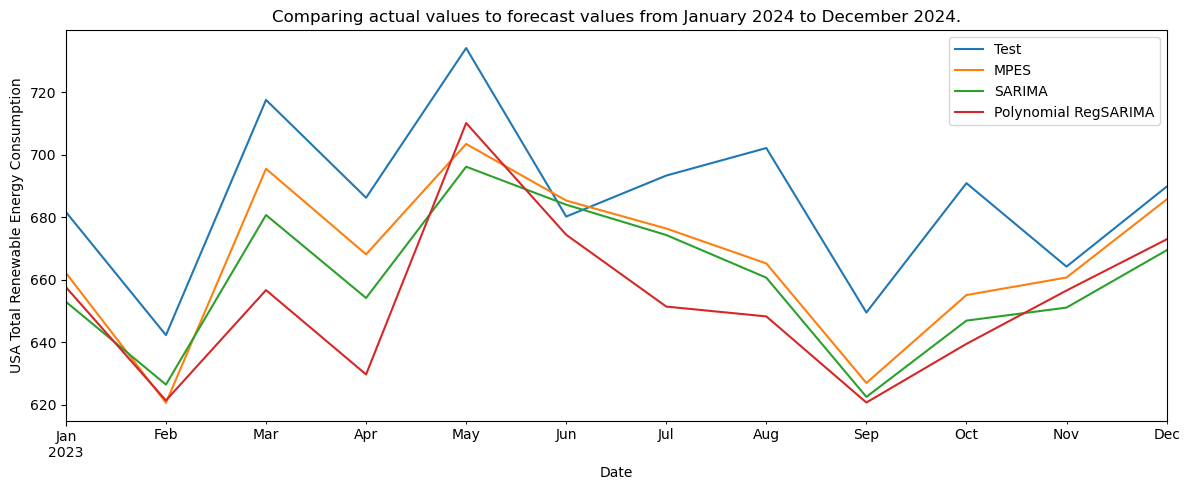

KeyError: "['lasso_regr'] not found in axis"

In [ ]:
forecast = pd.DataFrame(data = {"Test": y_test, "MPES": hwes_forecast["hwes_mm"],
                        "SARIMA": sarima_forecast["adj_gridmodel"],
                        "Polynomial RegSARIMA": sarimax_forecast})
print(forecast)

forecast.plot(figsize = (12, 5), title = "Comparing actual values to forecast values from January 2024 to December 2024.",
              xlabel = "Date", ylabel = "USA Total Renewable Energy Consumption")
plt.tight_layout()
plt.show()

evaluate = pd.concat([hwes_evaluate, sarima_evaluate, regression_evaluate, sarimax_evaluate], axis = 0)
evaluate = evaluate.drop(labels = "adj_gridarima_ln baseline_regr hwes_am hwes_ma hwes_aa poly_regr".split(" ")).sort_values(by = "MAPE TEST", ascending = True)
evaluate

In [ ]:
# sarima_resid

In [ ]:
# sarimax_resid

In [ ]:
# pd.concat([sarima_resid, sarimax_resid], axis = 1).rename(mapper = {0: "SARIMA", 1: "SARIMAX"}, axis = 1).to_excel("residual.xlsx")